In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

In [2]:
file = open("/content/drive/MyDrive/Colab Notebooks/ML programming/data/WISDM_ar_v1.1_raw.txt")

In [3]:
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [4]:
# 컬럼 추가
columns = ['user', 'activity', 'time', 'x', 'y', 'z']

In [5]:
df = pd.DataFrame(data = processedList, columns = columns)
df.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [6]:
df.isnull().sum()

,0
user,0
activity,0
time,0
x,0
y,0
z,0


In [7]:
df['activity'].value_counts()

,count
activity,
Walking,137375
Jogging,129392
Upstairs,35137
Downstairs,33358
Sitting,4599
Standing,3555


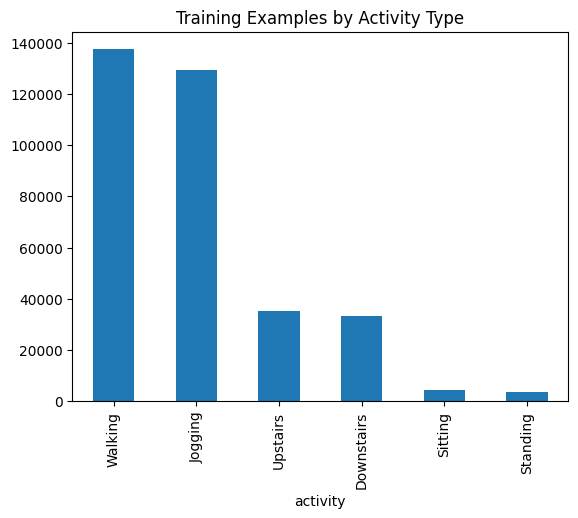

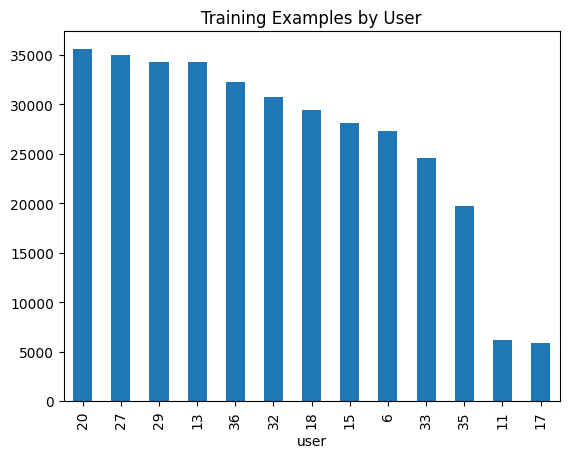

In [8]:
# Show how many training examples exist for each of the six activities
df["activity"].value_counts().plot(kind = "bar", title = "Training Examples by Activity Type")
plt.show()
# Better understand how the recordings are spread across the different users who participated in the study
df["user"].value_counts().plot(kind = "bar", title = "Training Examples by User")
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      343416 non-null  object
 1   activity  343416 non-null  object
 2   time      343416 non-null  object
 3   x         343416 non-null  object
 4   y         343416 non-null  object
 5   z         343416 non-null  object
dtypes: object(6)
memory usage: 15.7+ MB


In [10]:
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')

In [11]:
# activity 컬럼에 존재하는 각 고유값의 목록 가져오기
activities = df['activity'].value_counts().index

In [12]:
label = LabelEncoder()
df['activity'] = label.fit_transform(df['activity'])
df.head()

,user,activity,time,x,y,z
0,33,1,49105962326000,-0.694638,12.680544,0.503953
1,33,1,49106062271000,5.012288,11.264028,0.953424
2,33,1,49106112167000,4.903325,10.882658,-0.081722
3,33,1,49106222305000,-0.612916,18.496431,3.023717
4,33,1,49106332290000,-1.184970,12.108489,7.205164


In [13]:
activities

Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object', name='activity')

In [14]:
num_classes = 6

In [15]:
X = df[['x', 'y', 'z']]
y = df['activity']

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

,x,y,z,label
0,-0.258214,0.697059,0.044419,1
1,0.607502,0.483225,0.145310,1
2,0.590972,0.425654,-0.087046,1
3,-0.245817,1.575011,0.610023,1
4,-0.332596,0.610703,1.548620,1
...,...,...,...,...
343411,-0.105815,0.402609,-0.059530,5
343412,0.265839,0.435820,0.120852,5
343413,-0.031484,0.315054,0.230915,5
343414,-0.391003,0.094656,0.249259,5


In [17]:
# hop_size를 frame_size 보다 작게 설정하여 중복된 정보를 고려할 수 있게 함 (오버래핑)
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [18]:
def get_frames(df, frame_size, hop_size):
  """
  시계열 데이터를 CNN이 이해할 수 있게 재구성함.
  x,y,z 값을 각각의 채널로 나누고
  연속적인 데이터를 독립적인 여러개의 데이터로 나눔 (슬라이딩 윈도우 분할).
  이는 고정된 길이의 입력만 받을 수 있는 CNN 특성에서 기인함.

  Args:
    df: 데이터 프레임
    frame_size: 슬라이딩 윈도우 분할 사이즈
    hop_size: 슬라이딩 윈도우 사이즈

  Returns:
    frames: 분할된 데이터
    labels: 분할된 데이터의 레이블
  """

  N_FEATURES = 3

  frames = []
  labels = []
  for i in range(0, len(df) - frame_size, hop_size):
      x = df['x'].values[i: i + frame_size]
      y = df['y'].values[i: i + frame_size]
      z = df['z'].values[i: i + frame_size]

      # Retrieve the most often used label in this segment
      label = df['label'][i: i + frame_size].mode()[0]
      frames.append([x, y, z])
      labels.append(label)

  # Bring the segments into a better shape
  frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
  labels = np.asarray(labels)

  return frames, labels

In [19]:
X, y = get_frames(scaled_X, frame_size, hop_size)

In [20]:
X.shape, y.shape

((8584, 80, 3), (8584,))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6867, 80, 3), (1717, 80, 3), (6867,), (1717,))

In [22]:
X_train[0].shape, X_test[0].shape

((80, 3), (80, 3))

In [23]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 1D CNN 모델의 입력 형태에 맞게 텐서 차원 변경
# PyTorch의 nn.Conv1d는 (배치 크기, 채널 수, 시퀀스 길이) 형태를 기대
# 현재 데이터는 (배치 크기, 시퀀스 길이, 채널 수) 형태이므로, permute로 차원을 변경
X_train_tensor = X_train_tensor.permute(0, 2, 1)
X_test_tensor = X_test_tensor.permute(0, 2, 1)

print("--- PyTorch 텐서로 변환 후 형태 ---")
print(f"X_train 텐서의 형태: {X_train_tensor.shape}")
print(f"y_train 텐서의 형태: {y_train_tensor.shape}")
print(f"X_test 텐서의 형태: {X_test_tensor.shape}")
print(f"y_test 텐서의 형태: {y_test_tensor.shape}")

--- PyTorch 텐서로 변환 후 형태 ---
X_train 텐서의 형태: torch.Size([6867, 3, 80])
y_train 텐서의 형태: torch.Size([6867])
X_test 텐서의 형태: torch.Size([1717, 3, 80])
y_test 텐서의 형태: torch.Size([1717])


In [63]:
class CNN1D(nn.Module):
    """
    1D CNN 모델 아키텍처 정의.
    """
    def __init__(self, input_channels, num_classes):
        """
        모델의 레이어들을 초기화합니다.
        :param input_channels: 입력 데이터의 채널 수 (가속도계의 x, y, z축이므로 3)
        :param num_classes: 분류할 클래스의 총 개수
        """
        super(CNN1D, self).__init__()

        # 1. 합성곱 레이어 (Convolutional Layers)
        # 시계열 데이터의 특징을 추출하는 역할
        self.conv_layers = nn.Sequential(
            # 첫 번째 합성곱 레이어
            # 입력 채널 3 -> 출력 채널 64
            # 커널 사이즈 3, 패딩 1로 시퀀스 길이 유지
            nn.Conv1d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # 시퀀스 길이를 절반으로 줄임

            # 두 번째 합성곱 레이어
            # 입력 채널 64 -> 출력 채널 128
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)   # 시퀀스 길이를 다시 절반으로 줄임
        )

        # 2. 합성곱 레이어의 출력 크기 계산
        # 다음 완전 연결 레이어의 입력 크기를 자동으로 계산
        self._to_linear = self._calculate_conv_output(input_channels)

        # 3. 분류기 (Classifier)
        # 추출된 특징을 기반으로 최종 분류를 수행
        self.classifier = nn.Sequential(
            nn.Linear(self._to_linear, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)  # 최종 출력 노드는 클래스 수와 동일
        )

    def _calculate_conv_output(self, input_channels):
        """
        더미 입력으로 합성곱 레이어의 최종 출력 크기를 계산하는 헬퍼 메서드
        """
        # (1, 입력 채널, 시퀀스 길이) 형태의 더미 텐서 생성
        dummy_input = torch.zeros(1, input_channels, 80)
        output = self.conv_layers(dummy_input)

        # 출력 텐서의 모든 요소 수를 곱하여 크기 반환
        return int(np.prod(output.shape))

    def forward(self, x):
        """
        순전파(Forward Pass) 과정 정의
        :param x: 모델의 입력 텐서. 형태: (배치 크기, 채널 수, 시퀀스 길이)
        """
        # 합성곱 레이어를 통과
        x = self.conv_layers(x)

        # 완전 연결 레이어에 넣기 위해 텐서를 1차원으로 펼침
        x = x.view(x.size(0), -1)

        # 분류기 레이어를 통과하여 최종 예측값 반환
        x = self.classifier(x)
        return x


In [68]:
model = CNN1D(input_channels=3, num_classes=6)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN1D(
  (conv_layers): Sequential(
    (0): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2560, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [69]:
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# 3. 훈련 루프
epochs = 20
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    # 훈련 모드 설정
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # inputs와 labels를 GPU로 옮기기 (GPU 사용 시)

        inputs, labels = inputs.to(device), labels.to(device)

        # 기울기 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # 4. 검증 루프
    model.eval()
    running_test_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad(): # 기울기 계산 비활성화
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_test_loss / len(test_loader.dataset)
    test_accuracy = accuracy_score(all_labels, all_predictions)

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test Accuracy: {test_accuracy*100:.2f}%")

Epoch [1/20], Train Loss: 0.9460, Test Loss: 0.6478, Test Accuracy: 79.03%
Epoch [2/20], Train Loss: 0.5645, Test Loss: 0.4998, Test Accuracy: 83.17%
Epoch [3/20], Train Loss: 0.4672, Test Loss: 0.4388, Test Accuracy: 85.15%
Epoch [4/20], Train Loss: 0.4143, Test Loss: 0.4022, Test Accuracy: 85.26%
Epoch [5/20], Train Loss: 0.3746, Test Loss: 0.3700, Test Accuracy: 87.07%
Epoch [6/20], Train Loss: 0.3385, Test Loss: 0.3401, Test Accuracy: 87.42%
Epoch [7/20], Train Loss: 0.3089, Test Loss: 0.3138, Test Accuracy: 88.29%
Epoch [8/20], Train Loss: 0.2835, Test Loss: 0.2899, Test Accuracy: 88.93%
Epoch [9/20], Train Loss: 0.2601, Test Loss: 0.2619, Test Accuracy: 91.90%
Epoch [10/20], Train Loss: 0.2323, Test Loss: 0.2577, Test Accuracy: 91.90%
Epoch [11/20], Train Loss: 0.2142, Test Loss: 0.2284, Test Accuracy: 92.60%
Epoch [12/20], Train Loss: 0.1949, Test Loss: 0.2432, Test Accuracy: 91.15%
Epoch [13/20], Train Loss: 0.1853, Test Loss: 0.2155, Test Accuracy: 93.19%
Epoch [14/20], Train 

In [70]:
def plot_learningCurve_pytorch(train_losses, test_losses, test_accuracies, epochs):
    """
    PyTorch 모델의 학습 곡선을 시각화하는 함수.

    :param train_losses: 에폭별 훈련 손실(loss) 리스트
    :param test_losses: 에폭별 검증 손실(loss) 리스트
    :param test_accuracies: 에폭별 검증 정확도(accuracy) 리스트
    :param epochs: 총 에폭 수
    """
    epoch_range = range(1, epochs + 1)

    # 정확도(Accuracy) 그래프
    plt.plot(epoch_range, test_accuracies, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    # 손실(Loss) 그래프
    plt.plot(epoch_range, train_losses, label='Train Loss')
    plt.plot(epoch_range, test_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

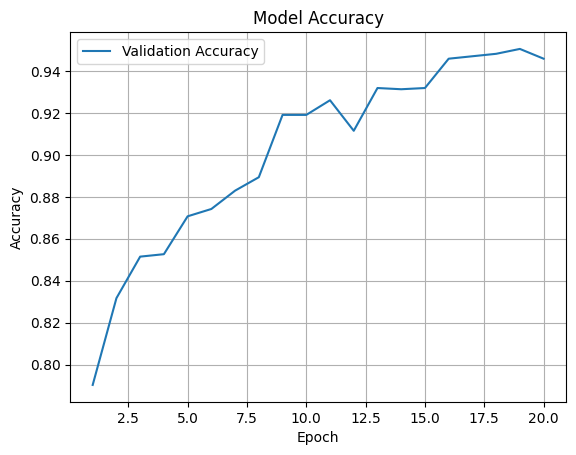

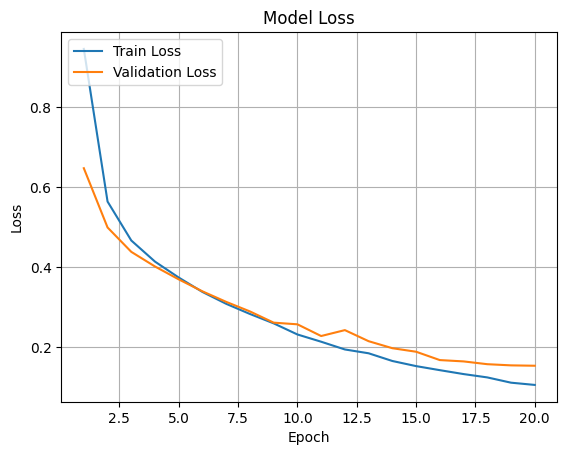

In [71]:
plot_learningCurve_pytorch(train_losses, test_losses, test_accuracies, epochs)

In [72]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch

# device 정의 (이미 코드 상단에 있다면 생략 가능)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the model to evaluation mode
model.eval()

# Perform prediction (model.predict equivalent)
with torch.no_grad():
    # 💡 X_test_tensor를 모델과 같은 device로 보냅니다.
    y_pred_test = model(X_test_tensor.to(device))

# Get the predicted class (highest probability)
# GPU에 있는 예측 결과를 CPU로 다시 가져와서 numpy로 변환해야 합니다.
y_pred_classes = torch.argmax(y_pred_test, dim=1).cpu().numpy()

# Get the true labels
y_true = y_test_tensor.cpu().numpy()

# Print the classification report
print("### Classification Report ###")
print(classification_report(y_true, y_pred_classes))

# Print the confusion matrix
print("\n### Confusion Matrix ###")
print(confusion_matrix(y_true, y_pred_classes))

### Classification Report ###
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       167
           1       0.97      0.99      0.98       646
           2       1.00      0.91      0.95        23
           3       0.94      0.94      0.94        18
           4       0.81      0.81      0.81       176
           5       0.96      0.99      0.98       687

    accuracy                           0.95      1717
   macro avg       0.93      0.90      0.91      1717
weighted avg       0.94      0.95      0.94      1717


### Confusion Matrix ###
[[125   5   0   0  27  10]
 [  0 638   0   0   2   6]
 [  1   0  21   0   1   0]
 [  0   0   0  17   1   0]
 [ 11  12   0   0 142  11]
 [  2   0   0   1   3 681]]


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

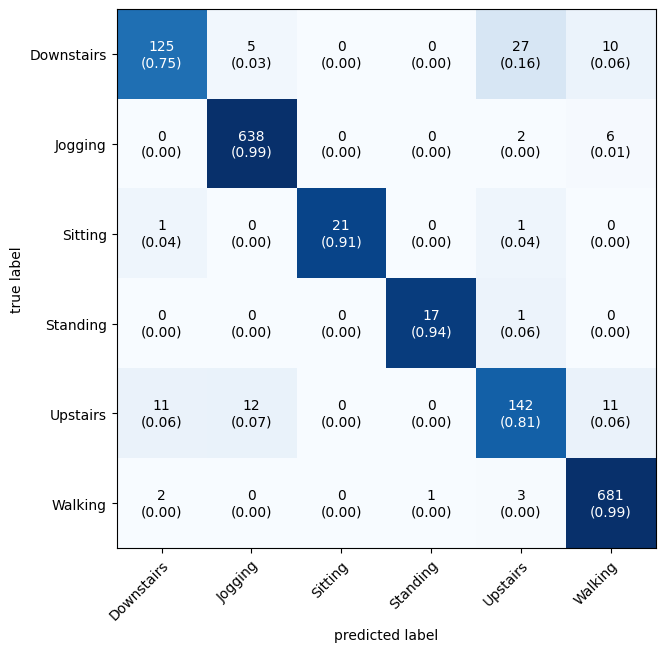

In [73]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# device 정의 (이미 코드 상단에 있다면 생략 가능)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

# with torch.no_grad()를 사용하여 기울기 계산을 비활성화합니다.
with torch.no_grad():
    # 💡 X_test_tensor를 모델과 같은 device로 보냅니다.
    predicted = model(X_test_tensor.to(device))

# 예측 결과를 CPU로 가져온 후 NumPy 배열로 변환합니다.
y_pred = torch.argmax(predicted, dim=1).cpu().numpy()

# 실제 라벨을 NumPy 배열로 변환
y_true = y_test_tensor.cpu().numpy()

# scikit-learn을 사용하여 혼동 행렬 생성
mat = confusion_matrix(y_true, y_pred)

# mlxtend를 사용하여 혼동 행렬 시각화
plot_confusion_matrix(
    conf_mat=mat,
    class_names=label.classes_,  # LabelEncoder에 저장된 클래스 이름 사용
    show_normed=True,
    figsize=(7, 7)
)